In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

1.8.1+cpu False


In [3]:
!rmdir /s/q detr 

In [4]:
!git clone https://github.com/woctezuma/detr.git

%cd detr/

!git checkout finetune

C:\Users\Yakov\Documents\_notebooks\juniper_notebooks\Detection\detr


Cloning into 'detr'...


branch 'finetune' set up to track 'origin/finetune'.


Switched to a new branch 'finetune'


In [5]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

In [28]:
first_class_index = 0
assert(first_class_index in [0, 1])

if first_class_index == 0:

  # There is one class, balloon, with ID n°0.

  num_classes = 1

  finetuned_classes = [
      'human',
  ]

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°1 here.  

else:

  # There is one class, balloon, with ID n°1.
  #
  # However, DETR assumes that indexing starts with 0, as in computer science,
  # so there is a dummy class with ID n°0.
  # Caveat: this dummy class is not the `no_object` class reserved by DETR.

  num_classes = 2

  finetuned_classes = [
      'N/A', 'human',
  ]

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°2 here.

print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 0
Parameter num_classes: 1
Fine-tuned classes: ['human']


In [9]:
%cd detr

[WinError 2] Не удается найти указанный файл: 'detr'
C:\Users\Yakov\Documents\_notebooks\juniper_notebooks\Detection\detr


In [ ]:
!python main.py \
  --dataset_file "custom" \
  --coco_path "C:\Users\Yakov\Documents\_notebooks\juniper_notebooks\Detection\data\custom" \
  --output_dir "outputs" \
  --resume "detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 300

### Plot logs

In [11]:
from util.plot_utils import plot_logs

from pathlib import Path

log_directory = [Path('outputs/')]

C:\Users\Yakov\Documents\_notebooks\juniper_notebooks\Detection\detr\util\plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


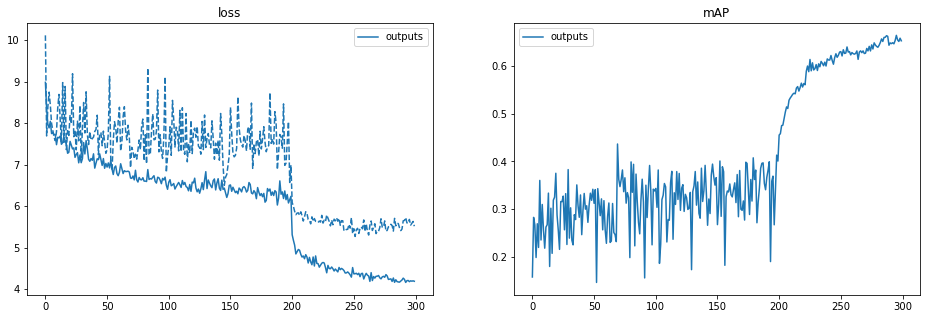

In [12]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

C:\Users\Yakov\Documents\_notebooks\juniper_notebooks\Detection\detr\util\plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
C:\Users\Yakov\Documents\_notebooks\juniper_notebooks\Detection\detr\util\plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
C:\Users\Yakov\Documents\_notebooks\juniper_notebooks\Detection\detr\util\plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeE

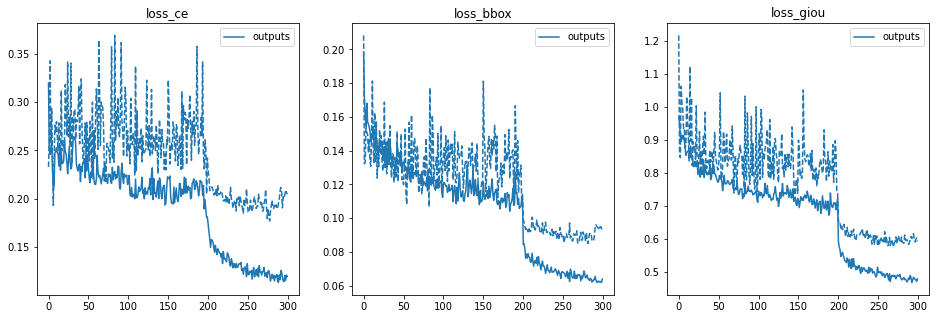

In [13]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

In [12]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

NameError: name 'plot_logs' is not defined

### Test

In [29]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('_human/outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Using cache found in C:\Users\Yakov/.cache\torch\hub\facebookresearch_detr_master


In [30]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [31]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [32]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
  return probas_to_keep, bboxes_scaled

In [33]:
def run_worflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  threshold = 0.4
    
  probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                             threshold=threshold)
    
  plot_finetuned_results(my_image,
                           probas_to_keep, 
                           bboxes_scaled)


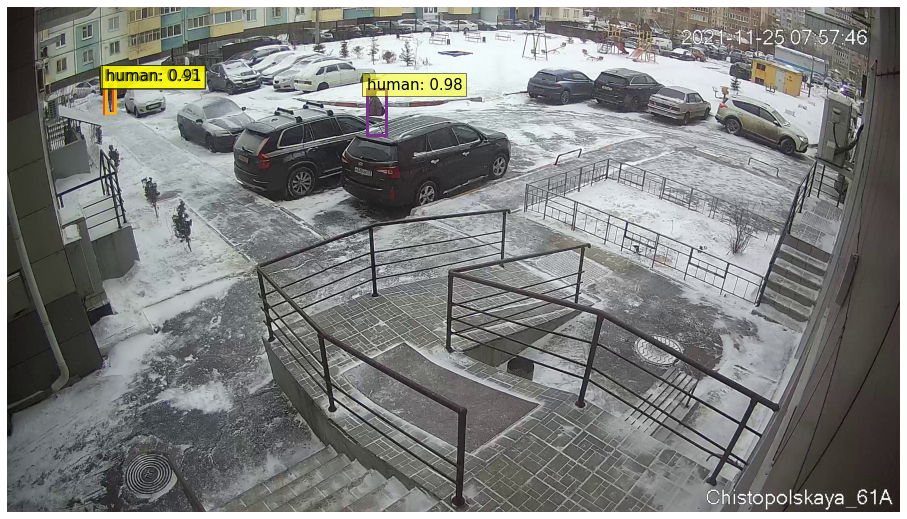

In [34]:
from PIL import Image

img_name = 'C:/Users/Yakov/Documents/_notebooks/juniper_notebooks/Detection/test/images/25-11-2021_04-57-47_AM.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)

### Predict

In [10]:
def boxes_predict(my_image, my_model, threshold=0.7):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(my_image).unsqueeze(0)

    # propagate through the model
    outputs = my_model(img)
    
    ##
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold
    print(probas[keep])
    ##xmin, ymin, xmax, ymax
    print(outputs['pred_boxes'][0, keep]) 
    


In [11]:
import os

threshold = 0.4
path_to_folder = "C:/Users/Yakov/Documents/_notebooks/juniper_notebooks/Detection/test/images"
def predict():
    simple_solution = []
    for detection_file in os.listdir(path_to_folder):
        img_name = detection_file.split('.')[0] + '.jpg'
        print(img_name)
        my_image = Image.open(path_to_folder+"/"+detection_file)
        img = transform(my_image).unsqueeze(0)
        outputs = model(img)
        
        probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
        keep = probas.max(-1).values > threshold
        tensor_probas = probas[keep].numpy()
        ##xmin, ymin, xmax, ymax
        tensor_boxes = outputs['pred_boxes'][0, keep].numpy()
        print(tensor_probas.size)
        
        for i in range(tensor_probas.size):
            conf = tensor_probas[i][0]
            xmin = tensor_boxes[i][0]
            xmax = tensor_boxes[i][1]
            ymin = tensor_boxes[i][2]
            ymax = tensor_boxes[i][3]
            simple_solution.append([img_name, 3, conf, xmin, xmax, ymin, ymax]) 
              
    return simple_solution

solution = predict()

0_23-11-2021_02-18-50_PM.jpg
0
0_23-11-2021_02-18-56_PM.jpg
0
0_23-11-2021_02-19-19_PM.jpg
0
0_23-11-2021_02-20-47_PM.jpg
1
0_23-11-2021_02-37-47_PM.jpg
0
0_23-11-2021_02-38-40_PM.jpg
0
0_23-11-2021_02-38-46_PM.jpg
1
0_23-11-2021_02-56-42_PM.jpg
0
0_23-11-2021_04-41-35_PM.jpg
0
0_23-11-2021_05-55-18_PM.jpg
0
0_23-11-2021_09-28-25_PM.jpg
1
0_24-11-2021_01-12-29_PM.jpg
0
0_24-11-2021_01-48-11_PM.jpg
0
0_24-11-2021_01-49-25_PM.jpg
1
0_24-11-2021_02-41-59_PM.jpg
0
0_24-11-2021_03-37-33_PM.jpg
0
0_24-11-2021_03-54-02_PM.jpg
0
0_24-11-2021_03-59-43_AM.jpg
2
0_24-11-2021_04-01-33_AM.jpg
0
0_24-11-2021_04-11-58_PM.jpg
0
0_24-11-2021_04-13-05_PM.jpg
4
0_24-11-2021_04-17-46_AM.jpg
0
0_24-11-2021_04-37-41_AM.jpg
0
0_24-11-2021_05-12-35_AM.jpg
0
0_24-11-2021_05-13-22_AM.jpg
0
0_24-11-2021_05-47-57_AM.jpg
0
0_24-11-2021_05-49-06_AM.jpg
0
0_24-11-2021_06-23-16_AM.jpg
0
0_24-11-2021_06-24-14_AM.jpg
0
0_24-11-2021_06-24-44_AM.jpg
0
0_24-11-2021_07-28-12_PM.jpg
0
0_24-11-2021_07-36-02_AM.jpg
0
0_24-11-

KeyboardInterrupt: 

In [ ]:
import pandas as pd
simple_solution = pd.DataFrame(solution, columns=['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax'])
simple_solution.to_csv("human_solution.csv", sep=';', index=False)

In [ ]:
simple_solution